<img style="max-width:20em; height:auto;" src="../graphics/A-Little-Book-on-Adversarial-AI-Cover.png"/>

Author: Nik Alleyne   
Author Blog: https://www.securitynik.com   
Author GitHub: github.com/securitynik   

Author Other Books: [   

            "https://www.amazon.ca/Learning-Practicing-Leveraging-Practical-Detection/dp/1731254458/",   
            
            "https://www.amazon.ca/Learning-Practicing-Mastering-Network-Forensics/dp/1775383024/"   
        ]   


This notebook ***(hop_skip_jump_black-box_targeted.ipynb)*** is part of the series of notebooks From ***A Little Book on Adversarial AI***  A free ebook released by Nik Alleyne

### HopSkipJumpAttack with ART: Black-box and Targeted  

### Lab Objectives: 
- Leverage HopSkipJumpAttack solely from a black box perspective   
- Perform an **targeted** attack using Adversarial Robustness Toolkit (ART)  
- Make inferences to remote API endpoint  
- Leverage the Adversarial Robustness Toolkit (ART)   
- Generate adversarial example with ART   
- Identify ways we can monitor for this type of activity  

### Step 1:  
**Ensure the previous lab infrastructure *hop_skip_jump_white-box.ipynb* is running**

In [21]:
import art
from art.attacks.evasion import HopSkipJump

# https://adversarial-robustness-toolbox.readthedocs.io/en/latest/modules/estimators/classification.html#blackbox-classifier
from art.estimators.classification import BlackBoxClassifier
import requests
import numpy as np
import json

import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

In [22]:
### Version of key libraries used  
print(f'Torch version used:  {torch.__version__}')
print(f'Numpy version used:  {np.__version__}')
print(f'Torchvision version used:  {torchvision.__version__}')
print(f'ART version used:  {art.__version__}')

Torch version used:  2.7.1+cu128
Numpy version used:  2.1.3
Torchvision version used:  0.22.1+cu128
ART version used:  1.20.1


In [23]:
# Setup the device to work with
# This should ensure if there are accelerators in place, such as Apple backend or CUDA, 
# we should be able to take advantage of it.

if torch.cuda.is_available():
    print('Setting the device to cuda')
    device = 'cuda'
elif torch.backends.mps.is_available():
    print('Setting the device to Apple mps')
    device = 'mps'
else:
    print('Setting the device to CPU')
    device = torch.device('cpu')

Setting the device to cuda


In [24]:
# Setup api inference endpoint
inference_url = 'http://127.0.0.1:5000/invocations'
inference_url

'http://127.0.0.1:5000/invocations'

In [25]:
# Define headers for our HTTP Post
headers = {'Content-Type' : 'application/json', 'User-agent': 'SecurityNik'}
headers

{'Content-Type': 'application/json', 'User-agent': 'SecurityNik'}

In [26]:
# Get some sample data
# Our previous model was built using the MNIST dataset
# We are just creating some sample data
# from this same distribution

# Setup a transform for the MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])

# Get the test data from MNIST
test_dataset = datasets.MNIST(root=r'/tmp/', download=True, train=False, transform=transform)

# Setup the test loader
test_loader = DataLoader(dataset=test_dataset, batch_size=1_000, shuffle=True)

X_sample, y_sample = next(iter(test_loader))
X_sample.shape, y_sample.shape

(torch.Size([1000, 1, 28, 28]), torch.Size([1000]))

# Step 2:   
Create a function to make the query   

In [27]:
# The function that serves as the callable
# We need this function for 
def make_query(x):

    # Setup our payload
    payload = json.dumps( { 'inputs' : x.tolist() })

    # make a HTTP post request to the inference endpoint
    prediction = requests.post(url=inference_url, data=payload, headers=headers).json()

    # Return the prediction results
    return np.array(prediction['predictions'])
    

In [28]:
# Test the function
# You should see a request at your mlflow endpoint for this   
# You should see something like this in the console: 
#  INFO:     127.0.0.1:41634 - "POST /invocations HTTP/1.1" 200 OK
make_query(x=X_sample).shape

(1000, 10)

In [29]:
# Setup the target_class. 
# This is the class we wish to force the all samples to become
tgt_class = 3
target_class_y = np.full_like(a=y_sample.numpy(), fill_value=tgt_class)
target_class_y[:10], target_class_y.shape

(array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3]), (1000,))

Let us now leverage ART's BlackBox classifier. This is similar to what a threat actor would do, when in contact with a remote API endpoint. 

### Step 3:   
Setup ART's BlackBoxClassifier   

In [30]:
# Start to target ART
# Create the attack classifier
# provide the predict function that we just created
# Specify that we are targeting a binary classification problem nb_classes=2
# Specify the input shape is coming from X.shape
# We will keep out results between -2 and +2
art_targeted_clf = BlackBoxClassifier(
    predict_fn=make_query, 
    nb_classes=10, 
    input_shape=X_sample.shape[1:], 
    clip_values=(-2, 2),
    )

art_targeted_clf

BlackBoxClassifier(model=None, clip_values=[-2.  2.], preprocessing=StandardisationMeanStd(mean=0.0, std=1.0, apply_fit=True, apply_predict=True), preprocessing_defences=None, postprocessing_defences=None, preprocessing_operations=[StandardisationMeanStd(mean=0.0, std=1.0, apply_fit=True, apply_predict=True)], nb_classes=10, predict_fn=<function make_query at 0x7fbe9c979260>, input_shape=torch.Size([1, 28, 28]))

In [31]:
# Setup a targeted attack
# Note the targeted=True
# Setup the attack
# The values I used are not meant to find the perfect model
# but instead to show how the attack works
art_targeted_attack = HopSkipJump(
    classifier=art_targeted_clf, 
    batch_size=32,
    max_eval = 100,    # Adjust this value to improve the chances of success
    max_iter = 10,      # Adjust this value to improve the chances of success
    targeted=False, 
    norm=np.inf,     # Experimenting with a infinity norm
    init_eval=1 
    )

art_targeted_attack

HopSkipJump(targeted=False, norm=inf, max_iter=10, max_eval=100, init_eval=1, init_size=100, curr_iter=0, batch_size=32, verbose=True, )

In [32]:
# Target the API to generate the adversarial examples  
# Also, because we specified this is a targeted attack,
# We now specify y=y_positive
# In the untargeted attack, we had y=None
x_test_targeted = art_targeted_attack.generate(x=X_sample.numpy(), y=target_class_y)


HopSkipJump:   0%|          | 0/1000 [00:00<?, ?it/s]

In [33]:
# Take a peek at 5 of the examples  
x_test_targeted.shape

(1000, 1, 28, 28)

In [34]:
# Use the ART classifier to maek predictions
preds_adv_logits = art_targeted_clf.predict(x_test_targeted)
adv_pred_labels = preds_adv_logits.argmax(axis=-1)
adv_pred_labels.shape

(1000,)

In [35]:
# Make predictions on the legit data
preds_legit = art_targeted_clf.predict(x= X_sample).argmax(axis=-1)
preds_legit[:10]

array([0, 3, 1, 4, 2, 5, 5, 5, 1, 1])

In [36]:
# What is the adversarial accuracy  
# As in how many samples were we able to force to our targeted class -> 3
adv_success_rate = ( adv_pred_labels == target_class_y ).sum() / len(adv_pred_labels)

print(f'The Adversarial Success rate is: {adv_success_rate * 100:.4f}%')

The Adversarial Success rate is: 7.2000%


In [37]:
# Let's calculate the perturbations
perturbation = (x_test_targeted - X_sample.numpy())
perturbation[:1]

array([[[[-0.14343855,  0.05701901, -0.23152883, -0.26078847,
           0.09559754,  0.2899347 ,  0.2101054 , -0.03876268,
           0.2899347 ,  0.05542085,  0.40444258, -0.40444258,
          -0.24744402, -0.05089862, -0.05280333,  0.10472814,
          -0.2101054 ,  0.09559754, -0.19077215, -0.37418738,
           0.17986304, -0.01341895, -0.0664513 ,  0.25896347,
          -0.05280333, -0.1080595 ,  0.20658305,  0.40444258],
         [-0.0493276 , -0.08803801,  0.1635603 , -0.03929146,
           0.08803801, -0.2823752 , -0.16198927,  0.18143407,
          -0.40444258, -0.0899803 ,  0.09559754,  0.40444258,
          -0.2101054 ,  0.2899347 , -0.40444258,  0.19946896,
           0.0258073 , -0.09559754, -0.2101054 , -0.00356502,
          -0.40444258, -0.2101054 ,  0.2101054 ,  0.2101054 ,
           0.1251832 , -0.40444258, -0.12185183,  0.09559754],
         [ 0.14343855, -0.24366477,  0.2101054 ,  0.09559754,
          -0.37418738,  0.09559754,  0.2101054 , -0.01199191,
      

### Step 4:  
Visualize what is going on.   

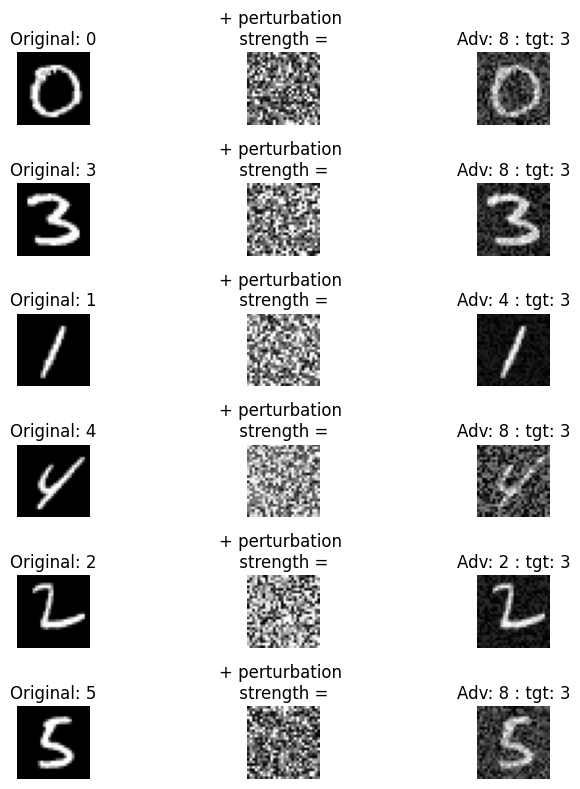

In [38]:
# Define the number of samples to view
num_samples_to_view = 6
plt.figure(figsize=(8,8))


for i in range(num_samples_to_view):
    # Get a sample from the original sample and plot it
    orig_image = X_sample[i].squeeze()

    # Get a sample from the adversarial examples
    adv_image = x_test_targeted[i].squeeze()

    # Plot the original samples
    plt.subplot(num_samples_to_view, 3, 3 * i + 1)
    plt.title(label=f'Original: {y_sample[i]}')
    plt.imshow(orig_image, cmap='gray')
    plt.axis('off')

    # Plot the perturbations
    plt.subplot(num_samples_to_view, 3, 3 * i + 2)
    plt.title(label=f'+ perturbation \n strength = ')
    # Let's ensure we see the strength of the perturbation
    plt.imshow(np.abs(perturbation[i]).squeeze(), cmap='gray')
    plt.axis('off')

    # Plot the adversarial examples
    plt.subplot(num_samples_to_view, 3, 3 * i + 3)
    plt.title(label=f'Adv: {adv_pred_labels[i]} : tgt: {tgt_class}')
    plt.imshow(x_test_targeted[i].squeeze(), cmap='gray')
    plt.axis('off')

plt.tight_layout()


So while we were not able to flip a significant portion of the labels to our target labels, we see however, that overall, we flipped the labels. Not exactly what we wanted. Maybe if we modify ART's hyper parameters, we will get better results. 

However, we achieved our objective of understanding how the HopSkipJump untargeted attack is performed. 


### Step 5: 
Make query to the real API endpoint 

In [39]:
# Use the adversarial examples against the real target if we wanted to
# This returns the logits
adv_targeted_logits = make_query(x_test_targeted)
adv_targeted_logits

array([[ 8.74588640e+07, -4.12844040e+07, -2.68492060e+07, ...,
        -1.99174180e+07,  1.17023480e+08,  1.22925220e+07],
       [-1.17338512e+08, -5.20418750e+06, -1.23235662e+06, ...,
        -4.85622400e+07,  8.08243840e+07, -5.40613680e+07],
       [-2.70047880e+07,  2.58191840e+07, -1.50635380e+07, ...,
         2.77503840e+07,  7.90624050e+06, -6.26321400e+06],
       ...,
       [-6.67751240e+07,  2.98688120e+07, -5.93167120e+07, ...,
         8.23546080e+07,  1.52259880e+07, -1.01645400e+07],
       [-5.04680440e+07, -2.50623220e+07,  3.34388240e+07, ...,
        -2.25536300e+07,  3.86860600e+07, -7.56666800e+07],
       [-1.05855248e+08, -9.55708200e+06, -4.19380080e+07, ...,
         3.09811860e+07,  9.26818300e+06, -3.13327660e+07]])

In [40]:
# Adversarial predictions from interaction with the real remote API endpoint
adv_preds = adv_targeted_logits.argmax(axis=-1)
adv_preds[:10]

array([8, 8, 4, 8, 2, 8, 8, 8, 8, 4])

### Step 6:   


### Mitigating this attack?   
See: **nftables_rate_limit_black-box_attackers.ipynb**    
    or    
**nftables_rate_limit_black-box_attackers_simplified.ipynb**   

### Step 4:   

### Lab Takeaways:  
- We were able to use ART's BlackBoxClassifier to perform a **targeted** black-box attack    
- We targeted a "remote" API endpoint   
- We generated an adversarial example   
- We saw this type of attack generates a large number of requests.   
- We learnt we can monitor this activity via our firewall  